# Testing Unet network

In [198]:
import tensorflow as tf
import os
import sys

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load data

In [90]:
data_train = "../../data_unet/stage1_train/"
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
seed = 42
random.seed = seed
np.random.seed = seed

('../../data_unet/stage1_train/',
 ['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552',
  '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1',
  '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
  '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed',
  '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf',
  '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21',
  '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426',
  '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339',
  '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776',
  '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe',
  '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a',
  '0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd',
  '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e',
  '05040e2e959c3f5632558fc9683fec88f0010026c555b49906634

In [43]:
train_ids = next(os.walk(data_train))[1]

In [68]:
train_ids[0]

'00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552'

In [48]:
data_train + train_ids[0] + "images/" + train_ids[0] + "/png"

'../../data_unet/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/png'

In [62]:
image = imread(data_train + train_ids[0] + "/images/" + train_ids[0] + ".png")[:,:,:IMG_CHANNELS]

In [64]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [141]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)

for n,id_file in enumerate(train_ids[:5]):
    image_to_read = data_train + id_file + "/images/" + id_file + ".png"
    image = imread(image_to_read)[:,:,:IMG_CHANNELS]
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = image
    
    mask_file = data_train + id_file + "/masks/*"
    all_masks = imread_collection(mask_file)
    series_masks = pd.Series(all_masks)
    image_maks = series_masks.apply(lambda m : resize(m, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True))
    Y_train[n] = image_maks.sum()
    


In [177]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in enumerate(train_ids):
    path = data_train + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask


Getting and resizing train images and masks ... 


In [158]:
Y_train_ = np.expand_dims(Y_train, axis = (2,0))

In [161]:
Y_train_ = Y_train.reshape(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1)

In [165]:
Y_train_.shape

(670, 128, 128, 1)

In [119]:
train_i = np.array(train_image) / 255

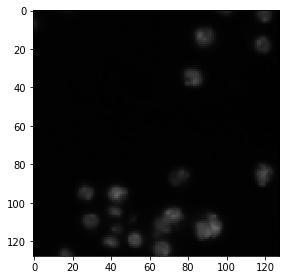

In [143]:
imshow(train_i[0])

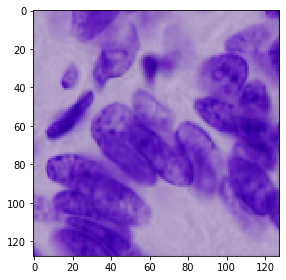

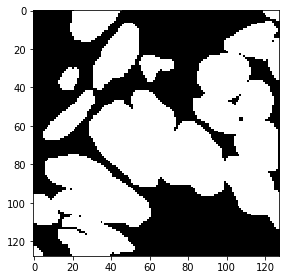

In [182]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [200]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics="accuracy")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv2d_38[0][0]                  
____________________________________________________________________________________________

In [201]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1,monitor='val_accuracy')
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True,monitor='val_accuracy')
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/10
38/38 [==============================] - 42s 1s/step - loss: 0.4281 - accuracy: 0.8104 - val_loss: 0.2149 - val_accuracy: 0.9163

Epoch 00001: val_accuracy improved from -inf to 0.91625, saving model to model-dsbowl2018-1.h5
Epoch 2/10
38/38 [==============================] - 41s 1s/step - loss: 0.2453 - accuracy: 0.9076 - val_loss: 0.2041 - val_accuracy: 0.9258

Epoch 00002: val_accuracy improved from 0.91625 to 0.92583, saving model to model-dsbowl2018-1.h5
Epoch 3/10
38/38 [==============================] - 41s 1s/step - loss: 0.1769 - accuracy: 0.9312 - val_loss: 0.1486 - val_accuracy: 0.9429

Epoch 00003: val_accuracy improved from 0.92583 to 0.94292, saving model to model-dsbowl2018-1.h5
Epoch 4/10
38/38 [==============================] - 40s 1s/step - loss: 0.1478 - accuracy: 0.9418 - val_loss: 0.1392 - val_accuracy: 0.9468

Epoch 00004: val_accuracy improved from 0.94292 to 0.94685, saving model to model-dsbowl2018-1.h5
Epoch 5/10
38/38 [=============================